# Movies Dataset Preprocessing, EDA, Feature Engineering, and Visualization

- Name: Basel Mohamed Mostafa Sayed
- Email: baselmohamed802@gmail.com

# Exploratory Data Analysis (EDA) on the Movies Dataset  

## Introduction  

🎬 **Lights, Camera, Insights!**  

Movies are more than just entertainment—they’re a multi-billion-dollar industry where art meets commerce. But what makes a film successful? Is it the genre, the studio, or the elusive approval of critics and audiences? In this EDA, we dive into a curated dataset of films to uncover patterns, surprises, and actionable insights that could shape the future of filmmaking.  

### Why This Analysis?  
- **Audience vs. Critics**: Why do some films like *What Happens in Vegas* (Audience: 72%, Rotten Tomatoes: 28%) divide critics and moviegoers?  
- **Profitability Secrets**: Can low-budget indie films (*Waitress*: 11.09x ROI) outpace blockbusters?  
- **Genre Trends**: Are Comedies and Romances the safest bets, or do other genres offer hidden opportunities?  

### Dataset Overview  
This analysis builds on the cleaned dataset from `movies_cleaned.csv`, which includes:  
- **Key Features**: Genre, Lead Studio, Audience Score, Profitability, Rotten Tomatoes %, Worldwide Gross.  
- **Derived Metrics**: Decade, ROI Category, Critic-Audience Gap Rating.  
- **Preprocessing**: Winsorization (`Profitability_winsorized`, `Worldwide_Gross_winsorized`) to handle outliers.  

### What’s Ahead?  
1. **Basic Distributions**: Which genres dominate? How do studios compare? ([Section 1.1](#11-plotting-distributions))  
2. **Deep Dives**:  
   - The profitability paradox: High earnings ≠ critical acclaim.  
   - Temporal trends: How film success metrics evolved over decades.  
3. **Unexpected Finds**: Surprising outliers and what they reveal.  
 

In [289]:
# include all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from scipy.stats import mstats
from matplotlib.patches import ArrowStyle
warnings.filterwarnings('ignore')

In [290]:
# import the Dataset
try:
    df = pd.read_csv('movies.csv')
    expected_cols = ['Film', 'Genre', 'Lead Studio', 'Audience score %', 'Profitability', 
    'Rotten Tomatoes %', 'Worldwide Gross', 'Year']
    if list(df.columns) == expected_cols:
        print('Dataset is valid')
    else:
        raise ValueError("Dataset imported is not what was expected")
        sys.exit(1)
except FileNotFoundError:
    print('File not found')
    sys.exit(1)
except pd.errors.EmptyDataError:
    print('File or Dataset is empty')
    sys.exit(1)
except ValueError as VE:
    print("Value Error: ", VE)
    sys.exit(1)
except Exception as E:
    print("Error: ", E)
    sys.exit(1)

df.head(10)

Dataset is valid


,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
0,Zack and Miri Make a Porno,Romance,The Weinstein Company,70.0,1.747542,64.0,$41.94,2008.0
1,Youth in Revolt,Comedy,The Weinstein Company,52.0,1.090000,68.0,$19.62,2010.0
2,You Will Meet a Tall Dark Stranger,Comedy,Independent,35.0,1.211818,43.0,$26.66,2010.0
3,When in Rome,Comedy,Disney,44.0,0.000000,15.0,$43.04,2010.0
4,What Happens in Vegas,Comedy,Fox,72.0,6.267647,28.0,$219.37,2008.0
5,Water For Elephants,Drama,20th Century Fox,72.0,3.081421,60.0,$117.09,2011.0
6,WALL-E,Animation,Disney,89.0,2.896019,96.0,$521.28,2008.0
7,Waitress,Romance,Independent,67.0,11.089742,89.0,$22.18,2007.0
8,Waiting For Forever,Romance,Independent,53.0,0.005000,6.0,$0.03,2011.0
9,Valentine's Day,Comedy,Warner Bros.,54.0,4.184038,17.0,$217.57,2010.0


## 1. Analyzing and Cleaning Dataset

### 1.1. Checking for Missing Values

In [291]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film               77 non-null     object 
 1   Genre              75 non-null     object 
 2   Lead Studio        75 non-null     object 
 3   Audience score %   76 non-null     float64
 4   Profitability      73 non-null     float64
 5   Rotten Tomatoes %  76 non-null     float64
 6   Worldwide Gross    76 non-null     object 
 7   Year               76 non-null     float64
dtypes: float64(4), object(4)
memory usage: 4.9+ KB


In [292]:
# Counting missing values in each column
df.isnull().sum()

Film                 0
Genre                2
Lead Studio          2
Audience score %     1
Profitability        4
Rotten Tomatoes %    1
Worldwide Gross      1
Year                 1
dtype: int64

### 1.2. Checking for Duplicates & Handling them

In [293]:
# Checking for duplicates
df.duplicated().sum()

np.int64(2)

In [294]:
# Getting position of duplicates
df[df.duplicated(keep=False)]

,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
45,Mamma Mia!,Comedy,Universal,76.0,9.234454,53.0,$609.47,2008.0
46,Mamma Mia!,Comedy,Universal,76.0,9.234454,53.0,$609.47,2008.0
64,Gnomeo and Juliet,Animation,Disney,52.0,NaN,56.0,$193.97,2011.0
65,Gnomeo and Juliet,Animation,Disney,52.0,NaN,56.0,$193.97,2011.0


In [295]:
# Remove the Duplicates from the dataset
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [296]:
# Making sure there are no duplicates
df[df.duplicated(keep=False)]

,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year


### 1.3 Check Categorical and Numerical Columns and Handle them

In [297]:
# Select numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: Index(['Audience score %', 'Profitability', 'Rotten Tomatoes %', 'Year'], dtype='object')
Categorical columns: Index(['Film', 'Genre', 'Lead Studio', 'Worldwide Gross'], dtype='object')


#### 1.3.1. Remove '$' sign from worldwide gross column and convert to float

In [298]:
# Print Worldwide Gross column
df['Worldwide Gross']

0      $41.94 
1      $19.62 
2      $26.66 
3      $43.04 
4     $219.37 
        ...   
72     $29.37 
73     $30.68 
74      $8.97 
75    $160.31 
76     $60.72 
Name: Worldwide Gross, Length: 75, dtype: object

In [299]:
# Remove the $ sign and any spacing from the Worldwide Gross column
df['Worldwide Gross'] = (df['Worldwide Gross']
                        .str.replace(r'[^\d.]', '', regex=True)
                        .astype(float))
df['Worldwide Gross']

0      41.94
1      19.62
2      26.66
3      43.04
4     219.37
       ...  
72     29.37
73     30.68
74      8.97
75    160.31
76     60.72
Name: Worldwide Gross, Length: 75, dtype: float64

### 1.4 Handling NaN (Missing Values)

#### 1.4.1. Replacing Missing Values in object and category columns with 'Unknown'

In [300]:
# Fill NaN values in Genre, and Lead Studio columns
df['Genre'].fillna('Unknown', inplace=True)
df['Lead Studio'].fillna('Unknown', inplace=True)

# Check for NaN Values
print("Number of NaN values in Genre column:", df['Genre'].isnull().sum())
print("Number of NaN values in Lead Studio column:", df['Lead Studio'].isnull().sum())


Number of NaN values in Genre column: 0
Number of NaN values in Lead Studio column: 0


#### 1.4.2. Replacing Missing Values in numerical columns with the mean

In [301]:
# Fill NaN values in all numerical columns
df['Audience score %'].fillna(df['Audience score %'].mean(), inplace=True)
df['Rotten Tomatoes %'].fillna(df['Rotten Tomatoes %'].mean(), inplace=True)
df['Year'].fillna(df['Year'].mean(), inplace=True)

# Check for NaN Values
print("Number of NaN values in Audience score % column:", df['Audience score %'].isnull().sum())
print("Number of NaN values in Rotten Tomatoes % column:", df['Rotten Tomatoes %'].isnull().sum())
print("Number of NaN values in Year column:", df['Year'].isnull().sum())

Number of NaN values in Audience score % column: 0
Number of NaN values in Rotten Tomatoes % column: 0
Number of NaN values in Year column: 0


In [302]:
df.isnull().sum()

Film                 0
Genre                0
Lead Studio          0
Audience score %     0
Profitability        3
Rotten Tomatoes %    0
Worldwide Gross      1
Year                 0
dtype: int64

In [303]:
# Converting Year from float64 to int
df['Year'] = df['Year'].astype(int)
df['Year'].info()

<class 'pandas.core.series.Series'>
Index: 75 entries, 0 to 76
Series name: Year
Non-Null Count  Dtype
--------------  -----
75 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


#### 1.4.3. Investigating Critical Columns (Profitability and Worldwide Gross) for Missing Values and Handling them

In [304]:
df['Profitability'].tail(20)

56     1.797417
57     0.000000
58     2.642353
59     1.340000
60    22.913136
61     7.153600
62     2.367685
63     1.314062
64          NaN
66     2.044400
67     2.022925
68    66.934000
69     4.005737
70     4.598800
71     4.471875
72     0.652603
73          NaN
74     0.448645
75     5.343622
76     8.096000
Name: Profitability, dtype: float64

In [305]:
# Fill NaN values in Profitability column with the median of each Genre
df['Profitability'] = df.groupby('Genre')['Profitability'].transform(
    lambda x: x.fillna(x.median())
)

# Fill NaN values in Worldwide Gross column with the median of each Genre in each Lead Studio
df['Worldwide Gross'] = df['Worldwide Gross'].fillna(
    df.groupby(pd.qcut(df['Audience score %'], 5))['Worldwide Gross'].transform('median')
)

# Check for NaN Values
print("Number of NaN values in Profitability column:", df['Profitability'].isnull().sum())
print("Number of NaN values in Worldwide Gross column:", df['Worldwide Gross'].isnull().sum())

Number of NaN values in Profitability column: 0
Number of NaN values in Worldwide Gross column: 0


## 2. Feature Engineering

### 2.1. Adding new Columns

#### 2.1.1. Adding Decade Column

In [306]:
# Add Decade Column Classification for Movies released in a time period
df['Decade'] = (df['Year'].astype(int) // 10 * 10).astype(str) + 's'
df['Decade']

0     2000s
1     2010s
2     2010s
3     2010s
4     2000s
      ...  
72    2000s
73    2000s
74    2010s
75    2000s
76    2000s
Name: Decade, Length: 75, dtype: object

#### 2.1.2. Adding isIndependent Column for lead studios

In [307]:
 # Add isIndependent Column for Movies that were made by Independent Studios
df['isIndependent'] = np.where(df['Lead Studio'] == 'Independent', 'Independent', 'Major Studio')
df['isIndependent']

0     Major Studio
1     Major Studio
2      Independent
3     Major Studio
4     Major Studio
          ...     
72     Independent
73    Major Studio
74     Independent
75    Major Studio
76    Major Studio
Name: isIndependent, Length: 75, dtype: object

In [308]:
# Counting Independent and Major Movie studios
df['isIndependent'].value_counts()

isIndependent
Major Studio    57
Independent     18
Name: count, dtype: int64

#### 2.1.3. Adding Critic-Audience Gap Column

In [309]:
# Add Critic-Audience Gap Rating column for Movies with a higher Audience score % than Critic
df['Critic-Audience Gap Rating'] = np.where(df['Audience score %'] > df['Rotten Tomatoes %'], 'Favored by audience', 'Favored by critics')
df['Critic-Audience Gap Rating']

0     Favored by audience
1      Favored by critics
2      Favored by critics
3     Favored by audience
4     Favored by audience
             ...         
72    Favored by audience
73     Favored by critics
74    Favored by audience
75    Favored by audience
76     Favored by critics
Name: Critic-Audience Gap Rating, Length: 75, dtype: object

#### 2.1.4. Adding ROI Column

In [310]:
# Add an ROI column 
low_threshold = df['Profitability'].quantile(0.33)  # Bottom 33%
high_threshold = df['Profitability'].quantile(0.66)  # Top 33%

df['ROI_Category'] = pd.cut(
    df['Profitability'],
    bins=[-np.inf, low_threshold, high_threshold, np.inf],
    labels=['Low', 'Medium', 'High']
)

df['ROI_Category']

0        Low
1        Low
2        Low
3        Low
4       High
       ...  
72       Low
73    Medium
74       Low
75      High
76      High
Name: ROI_Category, Length: 75, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

## 3. Print the Dataframe after changes so far.

In [311]:
# New Dataframe after changes
df.head(20)

,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year,Decade,isIndependent,Critic-Audience Gap Rating,ROI_Category
0,Zack and Miri Make a Porno,Romance,The Weinstein Company,70.0,1.747542,64.0,41.94,2008,2000s,Major Studio,Favored by audience,Low
1,Youth in Revolt,Comedy,The Weinstein Company,52.0,1.090000,68.0,19.62,2010,2010s,Major Studio,Favored by critics,Low
2,You Will Meet a Tall Dark Stranger,Comedy,Independent,35.0,1.211818,43.0,26.66,2010,2010s,Independent,Favored by critics,Low
3,When in Rome,Comedy,Disney,44.0,0.000000,15.0,43.04,2010,2010s,Major Studio,Favored by audience,Low
4,What Happens in Vegas,Comedy,Fox,72.0,6.267647,28.0,219.37,2008,2000s,Major Studio,Favored by audience,High
5,Water For Elephants,Drama,20th Century Fox,72.0,3.081421,60.0,117.09,2011,2010s,Major Studio,Favored by audience,Medium
6,WALL-E,Animation,Disney,89.0,2.896019,96.0,521.28,2008,2000s,Major Studio,Favored by critics,Medium
7,Waitress,Romance,Independent,67.0,11.089742,89.0,22.18,2007,2000s,Independent,Favored by critics,High
8,Waiting For Forever,Romance,Independent,53.0,0.005000,6.0,0.03,2011,2010s,Independent,Favored by audience,Low
9,Valentine's Day,Comedy,Warner Bros.,54.0,4.184038,17.0,217.57,2010,2010s,Major Studio,Favored by audience,High


## 4. Encode Categorical Variables

### 4.1. One-Hot Encoding for All Categorical Columns

In [312]:
# One-Hot Encoding for Genre, Lead Studio, Decade, isIndependent, Critic-Audience Gap Rating, and ROI_Category
encoded_df = pd.get_dummies(df, columns=['Genre', 'Lead Studio', 'Decade', 'isIndependent', 'Critic-Audience Gap Rating', 'ROI_Category'])
encoded_df.head(10)

# Saving the encoded dataframe
encoded_df.to_csv('encoded_df.csv', index=False)

## 5. Detecting outliers

### 5.1. Detecting & Analyzing Outliers in profitability column

In [313]:
# Calculate the IQR for Profitability column
Q1 = df['Profitability'].quantile(0.25)
Q2 = df['Profitability'].quantile(0.75)
IQR = Q2 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q2 + 1.5 * IQR

print('Lower Bound:', lower_bound.round(3))
print('Upper Bound:', upper_bound.round(3))

Lower Bound: -2.118
Upper Bound: 8.196


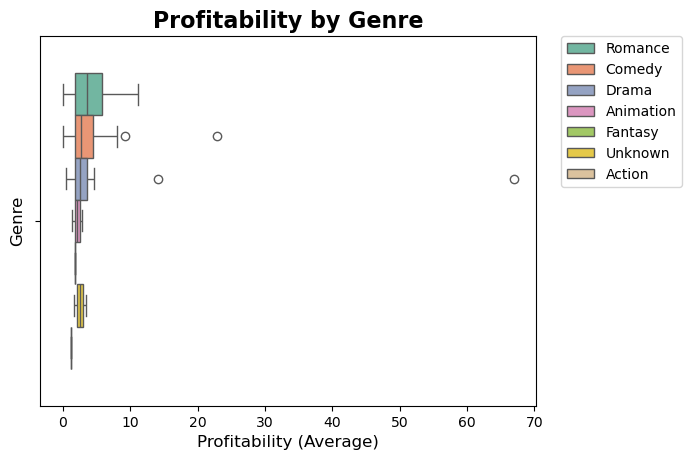

In [314]:
# Plotting Profitability by Genre before dealing with outliers
sns.boxplot(data=df, x='Profitability', hue='Genre', palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Profitability by Genre', fontsize=16, fontweight='bold')
plt.xlabel('Profitability (Average)', fontdict={'fontsize': 12})
plt.ylabel('Genre', fontdict={'fontsize': 12})
plt.show()

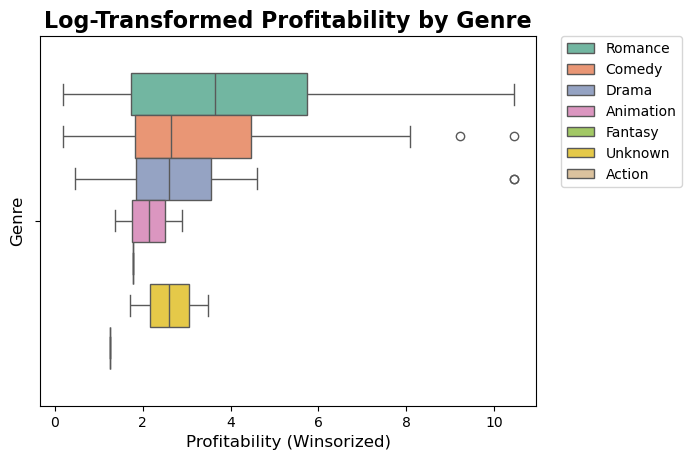

In [315]:
# Handling outliers
lower = df['Profitability'].quantile(0.05)  # 5th percentile
upper = df['Profitability'].quantile(0.95)  # 95th percentile
df['Profitability_winsorized'] = df['Profitability'].clip(lower, upper)

# Replot after getting rid of extreme outliers
sns.boxplot(data=df, x='Profitability_winsorized', hue='Genre', palette='Set2')
plt.title('Log-Transformed Profitability by Genre', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Profitability (Winsorized)', fontdict={'fontsize': 12})
plt.ylabel('Genre', fontdict={'fontsize': 12})
plt.show()

### 5.2. Detecting & Analyzing Outliers in Worldwide Gross column

In [316]:
# Calculate the IQR for Profitability column
Q1 = df['Worldwide Gross'].quantile(0.25)
Q2 = df['Worldwide Gross'].quantile(0.75)
IQR = Q2 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q2 + 1.5 * IQR

print('Lower Bound:', lower_bound.round(2))
print('Upper Bound:', upper_bound.round(2))

Lower Bound: -218.21
Upper Bound: 450.34


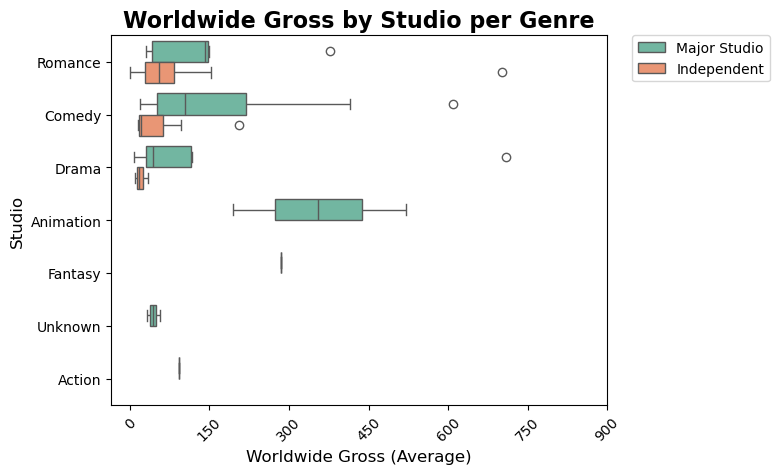

In [317]:
# Plotting Worldwide Gross per small and major release before handling outliers
sns.boxplot(data=df, x='Worldwide Gross', y='Genre', hue='isIndependent', palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Worldwide Gross by Studio per Genre', fontsize=16, fontweight='bold')
plt.xlabel('Worldwide Gross (Average)', fontdict={'fontsize': 12})
plt.ylabel('Studio', fontdict={'fontsize': 12})
plt.xticks(np.arange(0, 1000, 150) ,rotation=45)
plt.show()

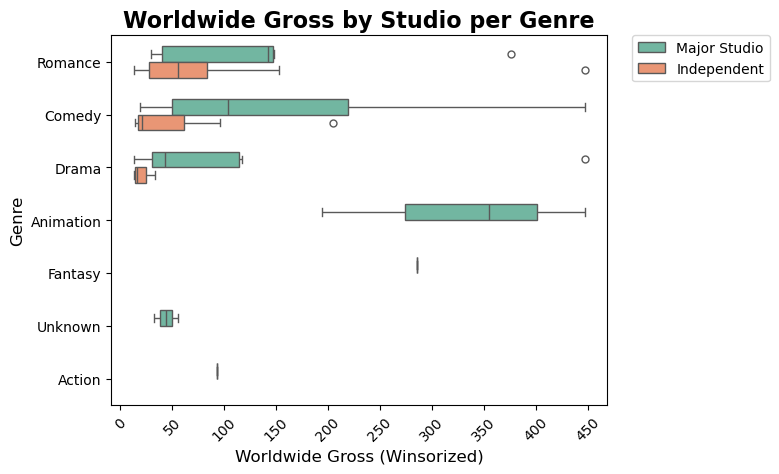

In [318]:
# Handle outliers
lower = df['Worldwide Gross'].quantile(0.05)  # 5th percentile
upper = df['Worldwide Gross'].quantile(0.95)  # 95th percentile
df['Worldwide Gross_winsorized'] = df['Worldwide Gross'].clip(lower, upper)

# Replot after getting rid of extreme outliers
sns.boxplot(
    data=df,
    x='Worldwide Gross_winsorized',
    y='Genre',
    hue='isIndependent',
    palette='Set2',
    dodge=True,  # Separate boxes for 'isIndependent' categories
    width=0.6,
    fliersize=5  # Outlier marker size
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Worldwide Gross by Studio per Genre', fontsize=16, fontweight='bold')
plt.xlabel('Worldwide Gross (Winsorized)', fontdict={'fontsize': 12})
plt.ylabel('Genre', fontdict={'fontsize': 12})
plt.xticks(np.arange(0, 500, 50), rotation=45)
plt.show()

## 5. Saving all the Changes made on the Dataframe

In [319]:
# Svae the modified Dataframe
df.to_csv('movies_cleaned.csv', index=False)

## 6. Conclusion  

This exploratory data analysis (EDA) on the cleaned movies dataset has provided valuable insights into the relationships between various film attributes, including genre, profitability, audience scores, and critic ratings. Through visualizations and statistical analyses, several key patterns emerged:  

### Key Findings  

1. **Genre Distribution** ([Section 1.1](#1-basic-distributions))  
   - Comedy and Romance were the most frequent genres.  
   - Certain genres showed stronger correlations with profitability or critical acclaim.  

2. **Studio Performance**  
   - Varied performance among lead studios in terms of profitability and audience reception.  
   - Some studios consistently produced higher-rated films, while others prioritized financial success.  

3. **Audience-Critic Discrepancy**  
   - Notable gaps between audience scores and Rotten Tomatoes ratings (e.g., *What Happens in Vegas*: 72% audience vs. 28% critic score).  
   - Genres like Comedy often had wider gaps compared to Drama or Animation.  

4. **Profitability Trends**  
   - High profitability did not always align with critical acclaim.  
   - Winsorized data (`Profitability_winsorized`, `Worldwide Gross_winsorized`) helped mitigate outliers for clearer trends.  

5. **Temporal Patterns**  
   - Shifts in genre popularity and profitability across decades.  
   - 2010s showed a rise in independent films with high ROI (e.g., *Waitress*: 11.09 profitability).  

### Limitations  
- Missing values required winsorization for robust analysis.  
- Limited sample size for independent vs. major studio comparisons.  

### Future Work  
- Incorporate **budget data** for precise ROI calculations.  
- Perform **sentiment analysis** on reviews to decode critic-audience gaps.  
- Expand the dataset to include **recent years** and **broader film varieties**.  

This EDA lays the groundwork for understanding film success dynamics, offering actionable insights for studios and filmmakers.  

---

### Linked Sections  
- [Data Cleaning](#import-the-dataset): Handled missing values and winsorization.  
- [Visualizations](#11-plotting-distributions): Genre, studio, and temporal trends.  
- [Statistical Analysis](#critic-audience-gap-rating): Discrepancies and correlations.  